In [ ]:
%pip install tensorflow==2.15.0 opencv-python mediapipe scikit-learn matplotlib

In [3]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# 2. Build keypoint using Mediapipe Holistic

In [4]:
# Initializing the Model
mp_holistic = mp.solutions.holistic

# Initializing the drawing utils
mp_drawing = mp.solutions.drawing_utils

In [5]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #color convertion
    image.flags.writeable = False
    results = model.process(image)
    #results = hands.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [6]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections 
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections 
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections 
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [7]:
def draw_styled_landmarks(image, results): 
    # Draw face connections 
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                              mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1))  
    # Draw pose connections 
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),  
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2))  
    # Draw left hand connections 
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,  
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),  
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2))  
    # Draw right hand connections   
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,  
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),  
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2))

In [40]:
cap = cv2.VideoCapture(0)

# Initializing current time and precious time for calculating the FPS
previousTime = 0
currentTime = 0

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        # Capture frame
        success, frame = cap.read()

        # Making predictions
        image, results = mediapipe_detection(frame, holistic)

        draw_styled_landmarks(image, results)

        # Calculating the FPS
        currentTime = time.time()
        fps = 1 / (currentTime-previousTime)
        previousTime = currentTime
        
        # Displaying FPS on the image
        cv2.putText(image, str(int(fps))+" FPS", (10, 470), 
                    cv2.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)
        # Press 'q' to quit
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
cap.release()
cv2.destroyAllWindows()

In [10]:
draw_styled_landmarks(frame, results)

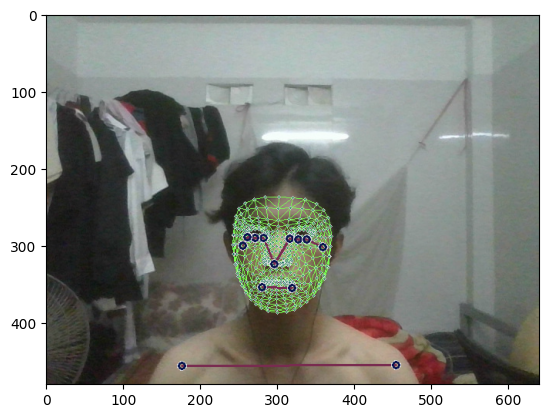

In [11]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values

In [15]:
results.right_hand_landmarks

In [8]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [17]:
extract_keypoints(results)[:10]

array([ 0.46368498,  0.67632776, -0.90570086,  0.99996763,  0.49454904,
        0.60818386, -0.85713089,  0.99993169,  0.51188099,  0.60851574])

# 4. Setup Folders for Collection

In [9]:
DATA_PATH = os.path.join("Data")

actions = np.array(['xin chao', 'cam on', 'toi yeu ban'])

# 30 videos
no_sequences = 30

# Each video has 30 frames
sequence_length = 30

In [10]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# 5. Collect Keypoint Values for Training and Testing

In [20]:
cap = cv2.VideoCapture(0)

# Initializing current time and precious time for calculating the FPS
previousTime = 0
currentTime = 0

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for action in actions:
        for sequence in range(no_sequences):
            for frame_num in range(sequence_length):
                # Capture frame
                success, frame = cap.read()

                frame = cv2.flip(frame, 1)
                # Making predictions
                image, results = mediapipe_detection(frame, holistic)

                draw_styled_landmarks(image, results)

                # Calculating the FPS
                currentTime = time.time()
                fps = 1 / (currentTime-previousTime)
                previousTime = currentTime

                # Displaying FPS on the image
                cv2.putText(image, str(int(fps))+" FPS", (10, 70),
                            cv2.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2)

                if frame_num == 0:
                    cv2.putText(image, 'STARTING COLLECTION', (120, 200),
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} video number {}'.format(action, sequence), (15, 12),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.waitKey(2000)
                else:
                    cv2.putText(image, 'Collecting frames for {} video number {}'.format(action, sequence), (15, 12),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    
                # Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)
                
                # Show to screen
                cv2.imshow('OpenCV Feed', image)
                
                # Press 'q' to quit
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
cap.release()
cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [2]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [11]:
label_map = {label:num for num, label in enumerate(actions)}

In [12]:
label_map

{'xin chao': 0, 'cam on': 1, 'toi yeu ban': 2}

In [13]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [15]:
X = np.array(sequences)

In [16]:
X.shape #video, frame, keypoints

(90, 30, 1662)

In [17]:
y = to_categorical(labels).astype(int)

In [18]:
y.shape 

(90, 3)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# 7. Build and Train LSTM Neural Network

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [62]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [55]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation="relu", input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation="relu"))
model.add(LSTM(64, return_sequences=False, activation="relu"))
model.add(Dense(64, activation="relu"))     #FC layer
model.add(Dense(32, activation="relu"))
model.add(Dense(actions.shape[0], activation="softmax"))

In [57]:
res = [0.7, 0.2, 0.5]

In [59]:
actions[np.argmax(res)]

'xin chao'

In [61]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [63]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000


3/3 [==============================] - 6s 100ms/step - loss: 34.6933 - categorical_accuracy: 0.3412
Epoch 2/2000
3/3 [==============================] - 0s 107ms/step - loss: 130.0516 - categorical_accuracy: 0.3412
Epoch 3/2000
3/3 [==============================] - 0s 111ms/step - loss: 110.4481 - categorical_accuracy: 0.3059
Epoch 4/2000
3/3 [==============================] - 0s 116ms/step - loss: 43.4137 - categorical_accuracy: 0.3294
Epoch 5/2000
3/3 [==============================] - 0s 108ms/step - loss: 27.6228 - categorical_accuracy: 0.2235
Epoch 6/2000
3/3 [==============================] - 0s 107ms/step - loss: 9.5439 - categorical_accuracy: 0.2706
Epoch 7/2000
3/3 [==============================] - 0s 132ms/step - loss: 23.2332 - categorical_accuracy: 0.3529
Epoch 8/2000
3/3 [==============================] - 0s 111ms/step - loss: 13.1235 - categorical_accuracy: 0.3412
Epoch 9/2000
3/3 [==============================] - 0s 125ms/step - loss: 17.3728 - categoric

In [23]:
score = model.evaluate(X_test, y_test)
score


1/1 [==============================] - 1s 1s/step - loss: 0.2726 - categorical_accuracy: 0.9130


[0.2725776731967926, 0.9130434989929199]

In [66]:
model.save('model1.h5')

D:\HAUI\ML\BTL\venv_ml\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
from tensorflow.keras.models import load_model
model = load_model('model1.h5')
model.summary()
# Param = 4 x (in x out + out x out + out)  in = 1662, out = 64


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596675 (2.28 MB)
Trainable params: 596675

# 8. Evaluation using Confusion Matrix and Accuracy

In [25]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [24]:
ypred = model.predict(X_test)

1/1 [==============================] - 1s 1s/step


In [26]:
ytrue = np.argmax(y_test, axis=1).tolist()
ypred = np.argmax(ypred, axis=1).tolist()

In [27]:
print(ypred)
print(ytrue)

[2, 1, 0, 0, 1, 2, 1, 0, 1, 0, 2, 1, 1, 2, 0, 0, 0, 2, 2, 0, 2, 0, 2]
[2, 1, 0, 0, 1, 2, 1, 0, 1, 0, 0, 1, 1, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2]


In [28]:
multilabel_confusion_matrix(ytrue, ypred)

array([[[12,  0],
        [ 2,  9]],

       [[17,  0],
        [ 0,  6]],

       [[15,  2],
        [ 0,  6]]], dtype=int64)

In [29]:
accuracy_score(ytrue, ypred)

0.9130434782608695

# 9. Test in Reak Time

In [53]:
colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0, 60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    return output_frame

In [54]:
# 1. New detection variables
sequence = []
sentence = []
threhold = 0.8

cap = cv2.VideoCapture(0)

# Initializing current time and precious time for calculating the FPS
previousTime = 0
currentTime = 0

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        # Capture frame
        success, frame = cap.read()

        # Making predictions
        image, results = mediapipe_detection(frame, holistic)

        draw_styled_landmarks(image, results)

        # 2. prediction
        keypoints = extract_keypoints(results)
        sequence.insert(0, keypoints)
        #sequence.append(keypoints)
        sequence = sequence[:30]

        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]

        if res[np.argmax(res)] > threhold:
            if len(sentence) > 0:
                if actions[np.argmax(res)] != sentence[-1]:
                    sentence.append(actions[np.argmax(res)])
            else:
                sentence.append(actions[np.argmax(res)])
        if len(sentence) > 3:
            sentence = sentence[-3:]
        
        # Probabilities
        image = prob_viz(res, actions, image, colors)

        # Print sentences
        cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, '   '.join(sentence), (3, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Calculating the FPS
        currentTime = time.time()
        fps = 1 / (currentTime-previousTime)
        previousTime = currentTime
        
        # Displaying FPS on the image
        cv2.putText(image, str(int(fps))+" FPS", (10, 470), 
                    cv2.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)
        # Press 'q' to quit
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 24ms/step
